# Validation: CM Prior sensitivity

This notebook:

* loads a library defined model. 
* loads the data according to the data preprocessor class.
* Tests the effect of different CM priors on the CM effectiveness

In [58]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
### Initial imports
import logging
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as T
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns
import scipy
import copy

logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from epimodel.pymc3_models.utils import geom_convolution
from epimodel.pymc3_models import cm_effect
from epimodel.pymc3_models.cm_effect.datapreprocessor import DataPreprocessor
import sensitivityplotlib as spl

sns.set_style("ticks")
%matplotlib inline

In [60]:
dp = DataPreprocessor(drop_HS=True)
data = dp.preprocess_data("../final_data/data_final.csv")

INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Healthcare Infection Control
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Performing Smoothing
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Albania
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Andorra
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Estonia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Iceland
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Latvia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Lithuania
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing New Zealand
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Singapore
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Slovakia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Performing Masking


## build and run model
skip this if you already have traces 

In [67]:
priors = ['half_normal', 'wide'] 
model_types = ['combined', 'active', 'death', 'combined_v3']
sigma_wide=10

In [68]:
for model_type in model_types:
    for prior in priors:
        print('Prior: ' + prior)
        print('Model: ' + model_type)
        if model_type=='combined':
            with cm_effect.models.CMCombined_Final(data) as model:
                if prior=='default':
                    model.build_model()
                if prior=='wide':
                    model.build_model(cm_prior_sigma=sigma_wide)
                if prior=='half_normal':
                    model.build_model(cm_prior='half_normal')
        if model_type=='active':
            with cm_effect.models.CMActive_Final(data) as model:
                if prior=='default':
                    model.build_model()
                if prior=='wide':
                    model.build_model(cm_prior_sigma=sigma_wide)
                if prior=='half_normal':
                    model.build_model(cm_prior='half_normal')
        if model_type=='death':
            with cm_effect.models.CMDeath_Final(data) as model:
                if prior=='default':
                    model.build_model()
                if prior=='wide':
                    model.build_model(cm_prior_sigma=sigma_wide)
                if prior=='half_normal':
                    model.build_model(cm_prior='half_normal')
        if model_type=='combined_v3':         
            with cm_effect.models.CMCombined_Final_V3(data_cm_leavout) as model:
                if prior=='default':
                    model.build_model()
                if prior=='wide':
                    model.build_model(cm_prior_sigma=sigma_wide)
                if prior=='half_normal':
                    model.build_model(cm_prior='half_normal')
                    
        model.run(1000, chains=8, cores=8)
        filename = 'out_final/cm_prior_' + model_type + '_' + str(prior) + '.txt'
        cm_trace = model.trace["CMReduction"]
        np.savetxt(filename, cm_trace) 

Prior: half_normal
Model: combined
out_final/cm_prior_combined_half_normal.txt
Prior: wide
Model: combined
out_final/cm_prior_combined_wide.txt
Prior: half_normal
Model: active
out_final/cm_prior_active_half_normal.txt
Prior: wide
Model: active
out_final/cm_prior_active_wide.txt
Prior: half_normal
Model: death
out_final/cm_prior_death_half_normal.txt
Prior: wide
Model: death
out_final/cm_prior_death_wide.txt


### Plot countermeasure effectiveness

In [56]:
legend_title = r'$\alpha$ Hyperprior $\sigma$'
legend_labels = ['0.1 (default)','10']
cm_labels = data.CMs 

#### plot combined model

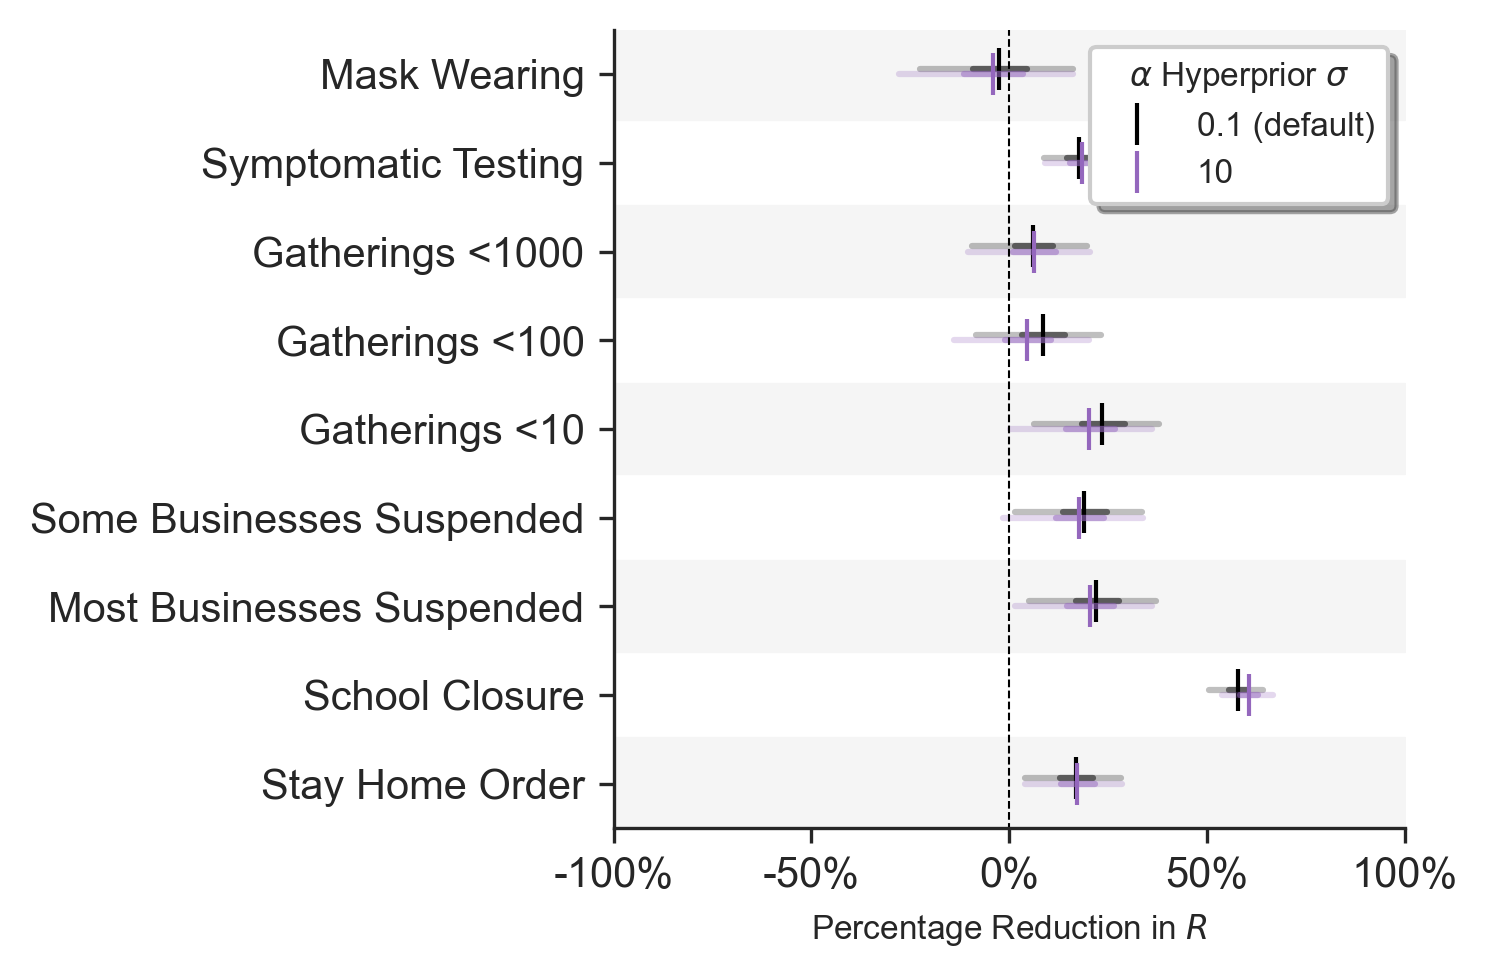

In [57]:
filenames = ['out_final/default_combined.txt', 'out_final/cm_prior_combined_wide.txt']
colors = ['black','tab:purple']

spl.plot_cm_effect_sensitivity(filenames, cm_labels, legend_labels,
                               legend_title=legend_title,
                               colors = colors)
plt.savefig('out_final/cm_prior_sensitivity_combined.pdf')

##### plot deaths

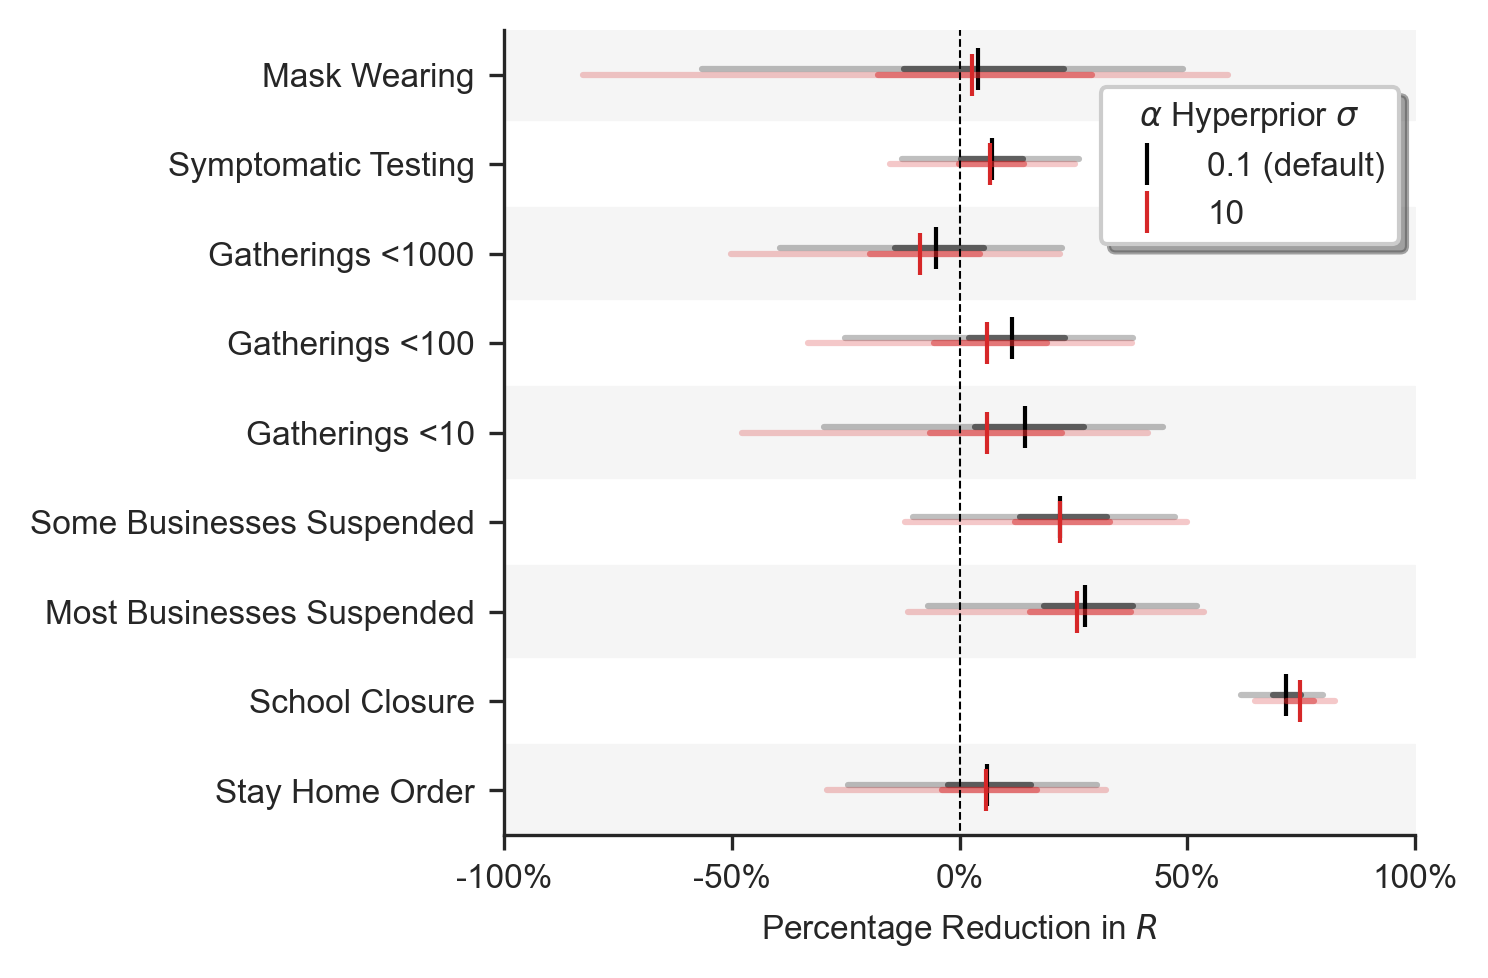

In [37]:
filenames = ['out_final/default_death.txt', 'out_final/cm_prior_death_wide.txt']
colors = colors = ['black','tab:red']

spl.plot_cm_effect_sensitivity(filenames, cm_labels, legend_labels,
                               legend_title=legend_title,
                               colors=colors, 
                               bbox_to_anchor=(1.,0.95))
plt.savefig('out_final/cm_prior_sensitivity_deaths_.pdf')

##### plot active

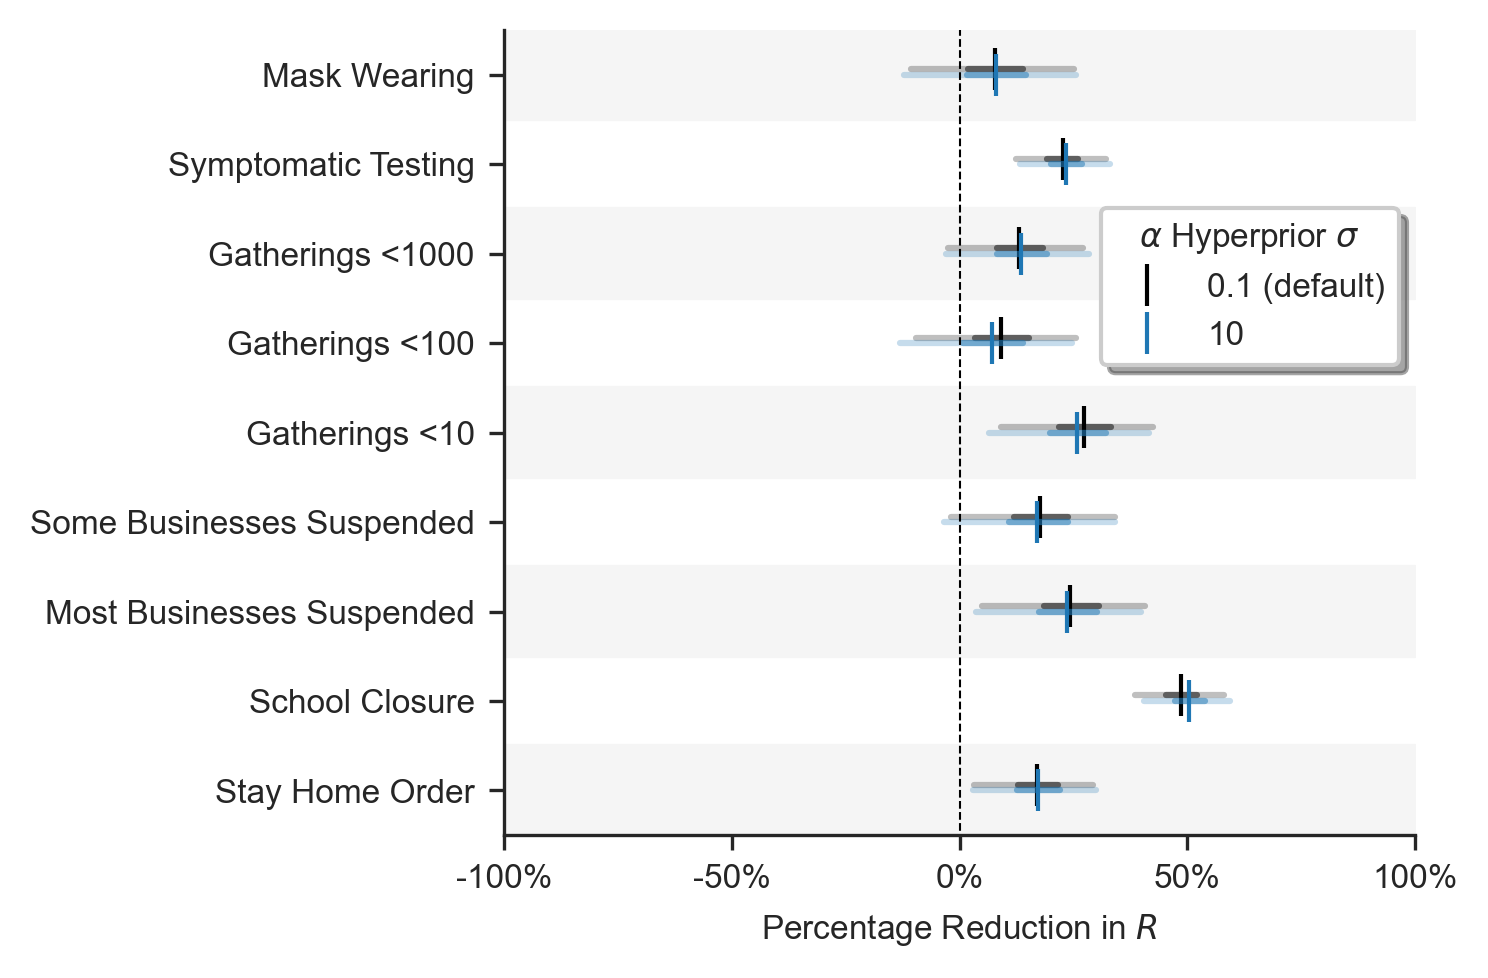

In [36]:
filenames = ['out_final/default_active.txt', 'out_final/cm_prior_active_wide.txt']
colors = ['black','tab:blue']

spl.plot_cm_effect_sensitivity(filenames, cm_labels, legend_labels,
                               legend_title=legend_title,
                               colors = colors,
                               bbox_to_anchor=(1.,0.8))
plt.savefig('out_final/cm_prior_sensitivity_active.pdf')